# Breaking ADAM

In case you haven't heard, one of the top papers at [ICLR 2018](https://iclr.cc/Conferences/2018) (pronounced:
eye-clear, who knew?) was [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ). In the
paper, the authors determine a flaw in the convergence proof of the ubiquitous ADAM optimizer. They also give an example
of a simple function for which ADAM does not converge to the correct solution. We've seen how torchbearer can be used
for simple function optimisation before and we can do something similar to reproduce the results
from the paper. We should note that this isn't a suggestion that you should necesarily use AMSGrad (the proposed solution from the paper), most work still uses either SGD with momentum or vanilla Adam and some other approaches have been proposed such as [AdamW](https://arxiv.org/abs/1711.05101) which may provide benefits. Our intention here is simply to show how this interesting failure case can be demonstrated with torchbearer.

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Torchbearer

First we install torchbearer if needed.

In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(torchbearer.__version__)

0.4.0.dev


Online Optimization
-----------------------------------

Online learning basically just means learning from one example at a time, in sequence. The function given in the paper
 has a unique minimum at $x=-1$ and is defined as follows:

\begin{equation}
f_t(x) = \begin{cases}1010x, & \text{for } t \; \texttt{mod} \; 101 = 1 \\ -10x, & \text{otherwise}\end{cases}
\end{equation}

We can then write this as a PyTorch model whose forward is a function of its parameters with the following:

In [2]:
import torch.nn as nn

class Online(nn.Module):
    def __init__(self):
        super().__init__()
        self.x = nn.Parameter(torch.zeros(1))

    def forward(self, _, state):
        """
        function to be minimised:
        f(x) = 1010x if t mod 101 = 1, else -10x
        """
        if state[torchbearer.BATCH] % 101 == 1:
            res = 1010 * self.x
        else:
            res = -10 * self.x

        return res

We now define a loss (simply return the model output) and a metric which returns the value of our parameter `x`:

In [3]:
def loss(y_pred, _):
    return y_pred


@torchbearer.metrics.to_dict
class est(torchbearer.metrics.Metric):
    def __init__(self):
        super().__init__('est')

    def process(self, state):
        return state[torchbearer.MODEL].x.data.item()

In the paper, `x` can only hold values in `[-1, 1]`. We don't strictly need to do anything but we can write
a callback that greedily updates `x` if it is outside of its range as follows:

In [4]:
@torchbearer.callbacks.on_step_training
def greedy_update(state):
    if state[torchbearer.MODEL].x > 1:
        state[torchbearer.MODEL].x.data.fill_(1)
    elif state[torchbearer.MODEL].x < -1:
        state[torchbearer.MODEL].x.data.fill_(-1)

Ideally, we would like to generate the graphs from the paper. To do this, we can use the tensorboard callback from torchbearer. However, we might also want to see a live graph directly in the notebook. For that we can use a callback which updates at the end of each step.

In [5]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Notebook doesn't seem to work right in Colab
if IN_COLAB:
  %matplotlib inline
else:
  %matplotlib notebook
  
from matplotlib import pyplot as plt

class Plotter():
    def __init__(self):
        self.plots = []
        self.fig = plt.figure(figsize=(5, 5))

    def make_plotter(self, name, c='k', step_size=100):
        idx = len(self.plots)
        self.plots.append(([], [], c, name))

        @torchbearer.callbacks.on_step_training
        @torchbearer.callbacks.only_if(lambda state: state[torchbearer.BATCH] % step_size == 0)
        def store(state):
            self.plots[idx][0].append(len(self.plots[idx][0]) * step_size)
            self.plots[idx][1].append(state[torchbearer.METRICS]['est'])

        @torchbearer.callbacks.on_step_training
        @torchbearer.callbacks.only_if(lambda state: state[torchbearer.BATCH] % (2 * step_size) == 0)
        def plot(state):
            plt.clf()
            for plot in self.plots:
                plt.plot(plot[0], plot[1], plot[2], label=plot[3])
            plt.legend()
            plt.xlabel('Step')
            plt.ylabel('Estimate')
            self.fig.canvas.draw()

        return torchbearer.callbacks.CallbackList([store, plot])

Given a figure, the above code will plot the estimate history every given number of steps, although in Colab this will just plot the graph at the end. Finally, we can train this model twice; once with ADAM and once with AMSGrad (included in PyTorch) with just a few
lines (this will take at least a few minutes on a GPU):

<IPython.core.display.Javascript object>


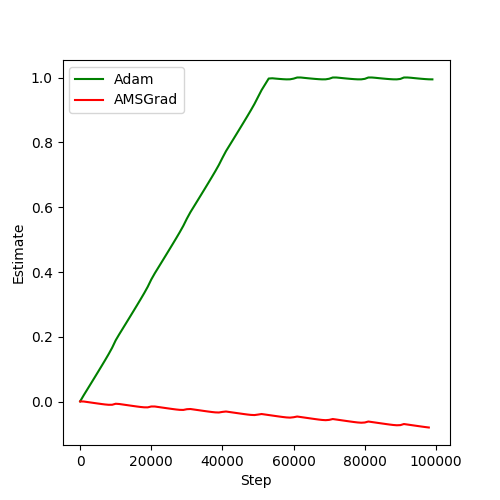

In [6]:
import sys
if 'tensorboardX' in sys.modules:
  from torchbearer.callbacks import TensorBoard
else:
  !pip install -q mock
  import mock
  TensorBoard = mock.MagicMock()
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
training_steps = 100000

plt.ion()
plotter = Plotter()
model = Online()
optim = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.99])
tbtrial = torchbearer.Trial(model, optim, loss, [est()],
                            callbacks=[
                                greedy_update,
                                plotter.make_plotter('Adam', c='g', step_size=1000),
                                TensorBoard(comment='adam', write_graph=False, write_batch_metrics=True, write_epoch_metrics=False)
                            ]).to(device)
_ = tbtrial.for_train_steps(training_steps).run(verbose=0)

model = Online()
optim = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.99], amsgrad=True)
tbtrial = torchbearer.Trial(model, optim, loss, [est()],
                            callbacks=[
                                greedy_update,
                                plotter.make_plotter('AMSGrad', c='r', step_size=1000),
                                TensorBoard(comment='amsgrad', write_graph=False, write_batch_metrics=True, write_epoch_metrics=False)
                            ]).to(device)
tbtrial.for_train_steps(training_steps).run(verbose=0)
plt.ioff()

Note that we have also logged to TensorBoard here (if tensorboardX was installed), which doesn't work on Colab. If you're running locally (for around 6000000 steps) and have tensorboard/tensorboardX installed then after completion, running  `tensorboard --logdir logs` and
navigating to [localhost:6006](http://localhost:6006), you will see a graph like the one in Figure 1 from the paper,
where the top line is with ADAM and the bottom with AMSGrad:

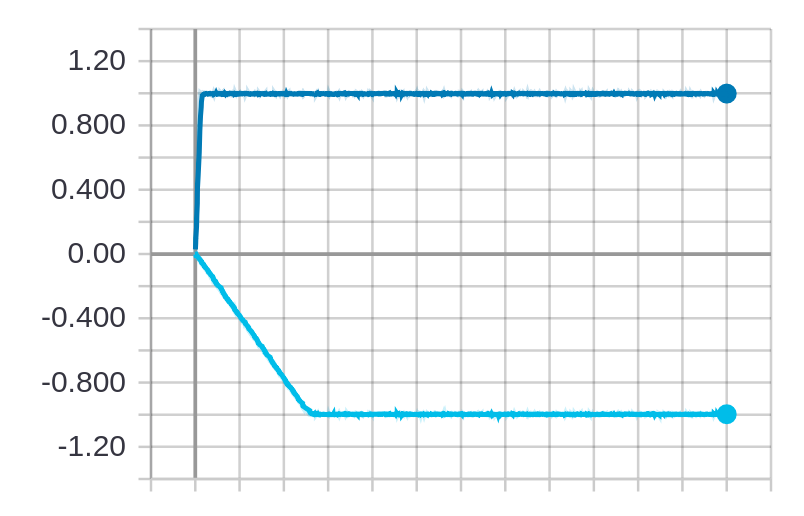

In [7]:
from IPython.display import Image 
Image('https://raw.githubusercontent.com/ecs-vlc/torchbearer/master/docs/_static/img/ams_grad_online.png', width=500)

Stochastic Optimization
------------------------------

To simulate a stochastic setting, the authors use a slight variant of the function, which changes with some probability:

\begin{equation}
f_t(x) = \begin{cases}1010x, & \text{with probability } 0.01 \\ -10x, & \text{otherwise}\end{cases}
\end{equation}

We can again formulate this as a PyToch model:

In [8]:
import random

class Stochastic(nn.Module):
    def __init__(self):
        super().__init__()
        self.x = nn.Parameter(torch.zeros(1))

    def forward(self, _):
        """
        function to be minimised:
        f(x) = 1010x with probability 0.01, else -10x
        """
        if random.random() <= 0.01:
            res = 1010 * self.x
        else:
            res = -10 * self.x

        return res

Using the loss, callback and metric from our previous example, we can train with the following:

<IPython.core.display.Javascript object>


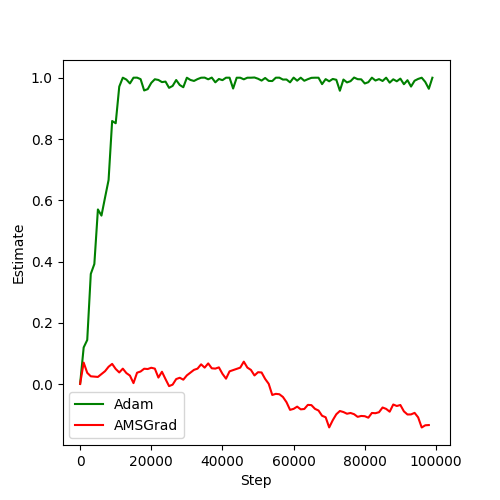

In [9]:
import sys
if 'tensorboardX' in sys.modules:
  from torchbearer.callbacks import TensorBoard
else:
  import mock
  TensorBoard = mock.MagicMock()
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
training_steps = 100000

plt.ion()
plotter = Plotter()
model = Stochastic()
optim = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.99])
tbtrial = torchbearer.Trial(model, optim, loss, [est()],
                            callbacks=[
                                greedy_update,
                                plotter.make_plotter('Adam', c='g', step_size=1000),
                                TensorBoard(comment='adam', write_graph=False, write_batch_metrics=True, write_epoch_metrics=False)
                            ]).to(device)
tbtrial.for_train_steps(training_steps).run(verbose=0)

model = Stochastic()
optim = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.99], amsgrad=True)
tbtrial = torchbearer.Trial(model, optim, loss, [est()],
                            callbacks=[
                                greedy_update,
                                plotter.make_plotter('AMSGrad', c='r', step_size=1000),
                                TensorBoard(comment='amsgrad', write_graph=False, write_batch_metrics=True, write_epoch_metrics=False)
                            ]).to(device)
tbtrial.for_train_steps(training_steps).run(verbose=0)
plt.ioff()

After execution has finished, again running `tensorboard --logdir logs` and navigating to
[localhost:6006](http://localhost:6006) <http://localhost:6006>, we see another graph similar to that of the stochastic setting in Figure 1 of
the paper, where the top line is with ADAM and the bottom with AMSGrad:

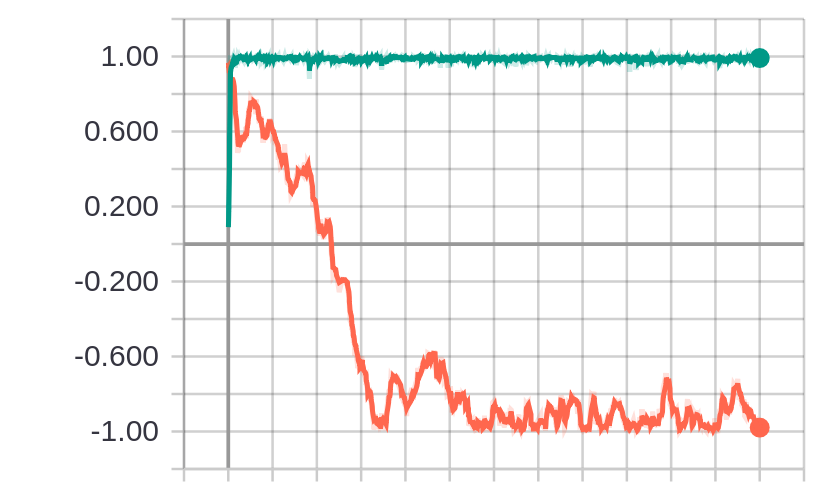

In [10]:
from IPython.display import Image 
Image('https://raw.githubusercontent.com/ecs-vlc/torchbearer/master/docs/_static/img/ams_grad_stochastic.png', width=500)

Conclusions
------------------------------------

So, whatever your thoughts on the AMSGrad optimizer in practice, it's probably the sign of a good paper that you can
re-implement the example and get very similar results without having to try too hard and (thanks to torchbearer) only
writing a small amount of code. The paper includes some more complex, 'real-world' examples, can you re-implement those?
